# Exercise 4

## Import packages

In [27]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [28]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # TODO: set the model to train mode
    model.train()
    
    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    for i, (images, ground_truth) in enumerate(train_loader):
        
        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()
        
        # TODO: run the network
        prediction = model(images)
        
        # TODO: compute negative log likelihood loss
        nll = F.nll_loss(prediction, ground_truth)
        
        # TODO: do backpropagation
        nll.backward()
        
        # TODO: optimize
        optimizer.step()
        
        # TODO: print current loss for every nth ("log_interval"th) iteration
        if i % log_interval == 0:
            print(f'Train Epoch: {epoch} [{i * len(images)}/{len(train_loader.dataset)} '
                f'({100. * i / len(train_loader):.0f}%)]\tLoss: {nll.item():.6f}')



We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [29]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [30]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)

       

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = torch.flatten(x, start_dim = 1) 
        
        # TODO: run network layers
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        x = self.fc5(x)
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x, dim = 1)
        
        return output

/opt/anaconda3/envs/3dcv-students/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.411343
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.283128
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.331658
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.285586
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.300373
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.302655
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.307592
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.286853
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.310096
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.060957

Test set: Average loss: 1.8548, Accuracy: 2878/10000 (28.78%)



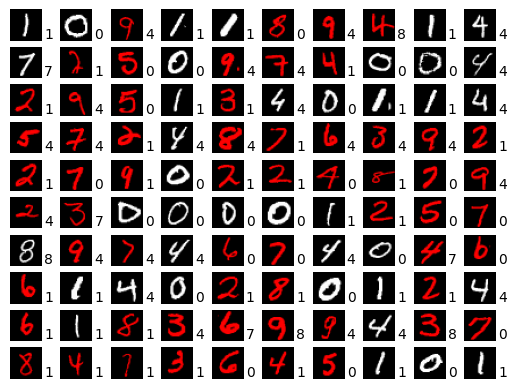

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.782196
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.621179
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.426069
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.358528
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.204986
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.941605
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.060450
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.719894
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.019975
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.537856

Test set: Average loss: 0.6685, Accuracy: 8497/10000 (84.97%)



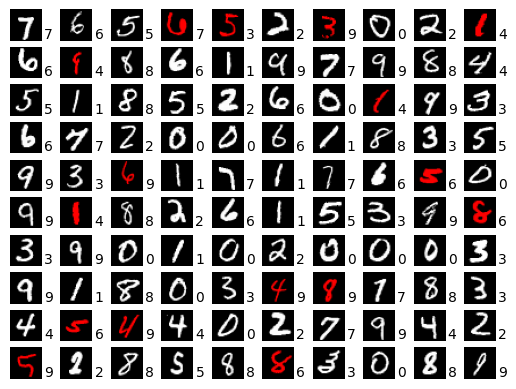

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.653483
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.376879
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.488382
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.517821
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.574322
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.484830
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.585308
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.382452
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.418910
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.230806

Test set: Average loss: 0.4483, Accuracy: 8783/10000 (87.83%)



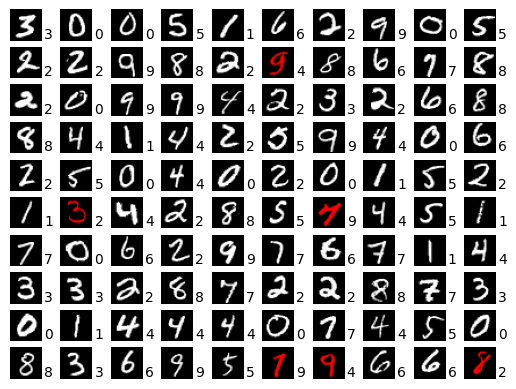

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.490360
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.201995
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.174741
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.125627
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.289647
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.076953
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.354724
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.231841
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.261799
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.183517

Test set: Average loss: 0.2806, Accuracy: 9334/10000 (93.34%)



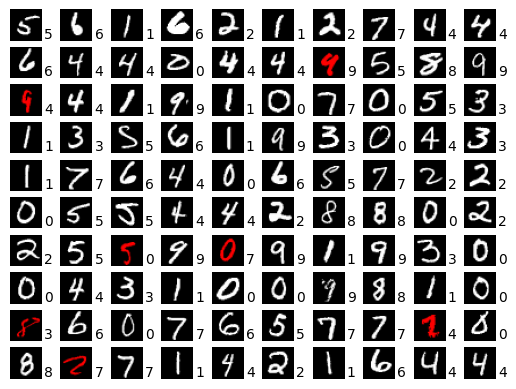

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.104987
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.228655
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.074468
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.130094
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.260602
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.111350
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.265198
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.223173
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.200260
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.120079

Test set: Average loss: 0.2166, Accuracy: 9512/10000 (95.12%)



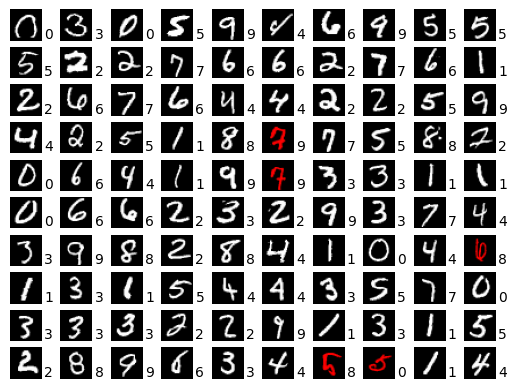

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.227833
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.087211
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.044717
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.154417
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.078729
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.141109
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.282398
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.316781
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.240873
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.319068

Test set: Average loss: 0.2028, Accuracy: 9529/10000 (95.29%)



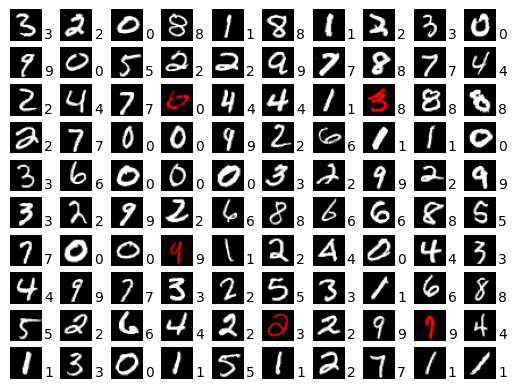

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.176894
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.047924
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.131779
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.081537
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.240905
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.181383
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.043514
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.042758
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.339401
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.086152

Test set: Average loss: 0.1968, Accuracy: 9544/10000 (95.44%)



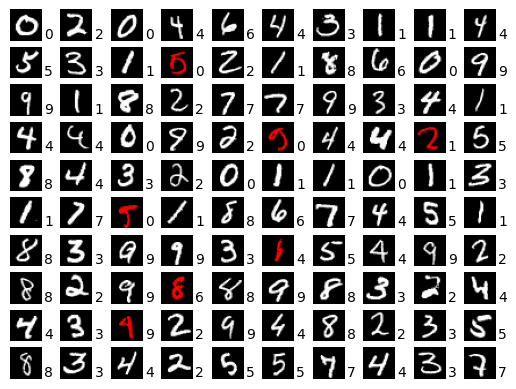

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.033766
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.151905
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.231200
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.174684
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.272069
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.032029
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.075504
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.079230
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.110865
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.134493

Test set: Average loss: 0.1854, Accuracy: 9566/10000 (95.66%)



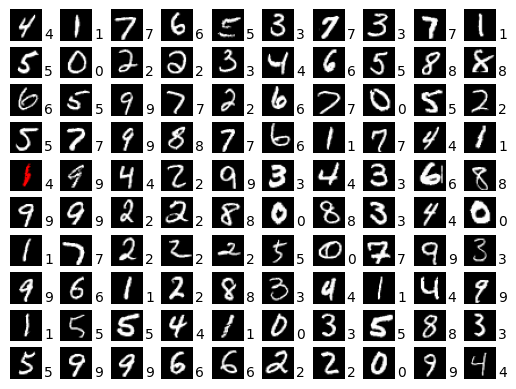

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.123538
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.166371
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.244934
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.055020
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.238967
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.063456
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.288248
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.153547
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.053215
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.126310

Test set: Average loss: 0.1845, Accuracy: 9572/10000 (95.72%)



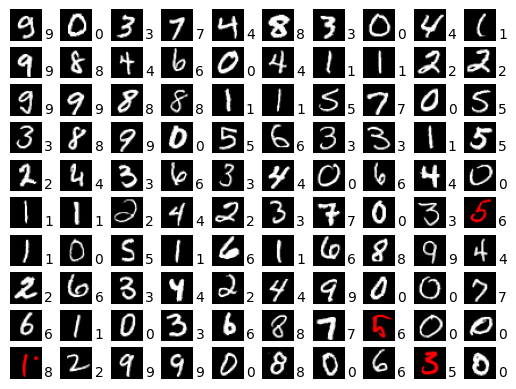

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.078015
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.055317
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.156784
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.046093
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.278981
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.039231
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.100830
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.225926
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.258723
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.036299

Test set: Average loss: 0.1825, Accuracy: 9579/10000 (95.79%)



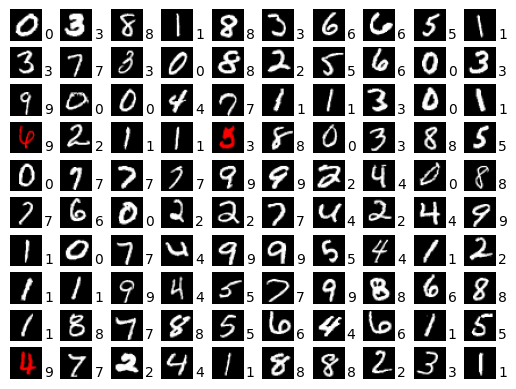

In [12]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = FCNet1()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")

In [31]:
class FCNet2(nn.Module):
    def __init__(self):
        super(FCNet2, self).__init__()
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)

        output = F.log_softmax(x, dim=1)

        return output

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300049
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.256574
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.412274
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.107516
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.296196
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.153605
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.086000
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.054854
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.280324
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.234699

Test set: Average loss: 0.2106, Accuracy: 9400/10000 (94.00%)



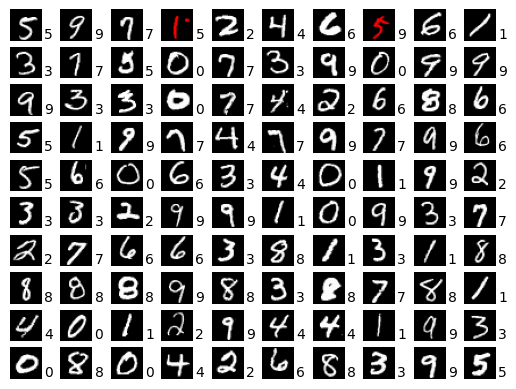

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.091821
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.149098
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.168761
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.116091
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.019039
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.123091
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.019517
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.076168
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.279317
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.045354

Test set: Average loss: 0.0997, Accuracy: 9722/10000 (97.22%)



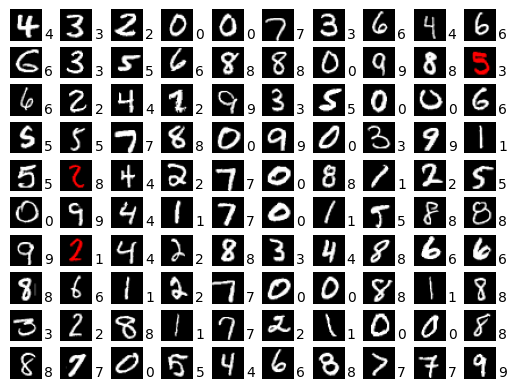

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.069301
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.013128
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.123146
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.079957
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.213377
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.003463
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.020434
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.011108
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.046596
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.014095

Test set: Average loss: 0.0864, Accuracy: 9774/10000 (97.74%)



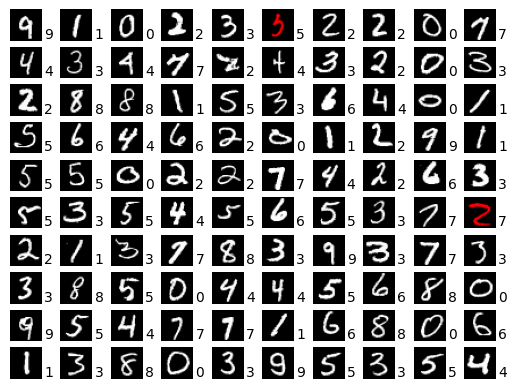

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.094444
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.038767
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.033433
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.030512
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.025069
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.002156
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.005145
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.062959
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.013270
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.106324

Test set: Average loss: 0.0810, Accuracy: 9795/10000 (97.95%)



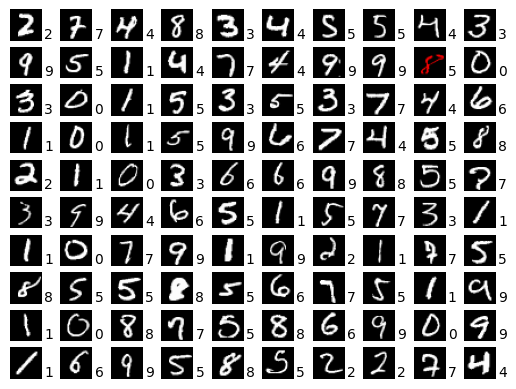

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.005126
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.000855
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.002229
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.094415
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.000432
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.001064
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.016742
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.002937
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.009223
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.002655

Test set: Average loss: 0.0807, Accuracy: 9817/10000 (98.17%)



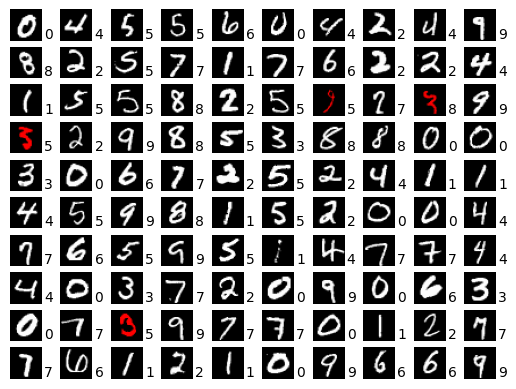

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.000336
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.001124
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.004184
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.007930
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.034550
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.017603
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.000989
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.006614
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.000426
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.000995

Test set: Average loss: 0.0876, Accuracy: 9817/10000 (98.17%)



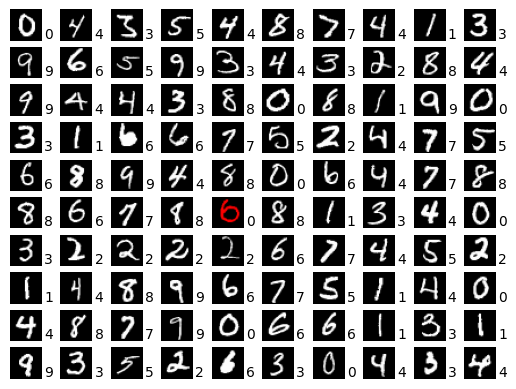

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.016418
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.051434
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.012862
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.000789
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.002798
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.000542
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.000237
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.005129
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.001228
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.001077

Test set: Average loss: 0.0894, Accuracy: 9816/10000 (98.16%)



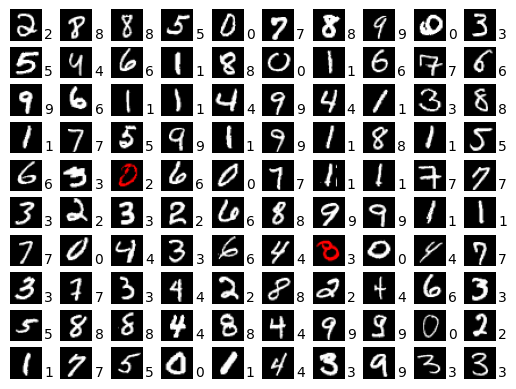

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.000430
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.000864
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.001367
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.016903
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.004296
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.000924
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.002747
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.024062
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.000374
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.000929

Test set: Average loss: 0.0946, Accuracy: 9809/10000 (98.09%)



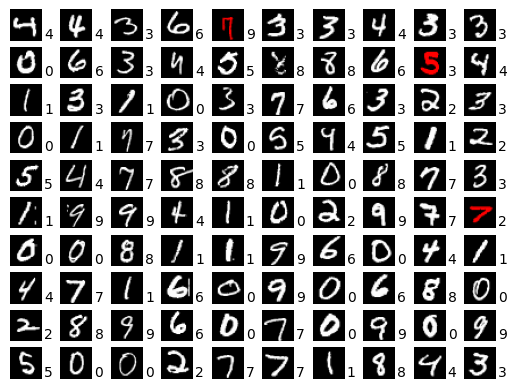

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.000199
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.005434
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.185020
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.000285
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.161780
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.003314
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.013121
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.000785
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.001746
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.017154

Test set: Average loss: 0.0950, Accuracy: 9814/10000 (98.14%)



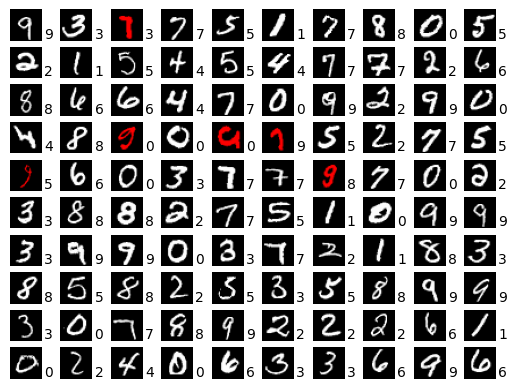

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.044427
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.000982
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.001789
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.003171
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.000133
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.000695
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.000666
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.000272
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.000101
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.001361

Test set: Average loss: 0.0975, Accuracy: 9810/10000 (98.10%)



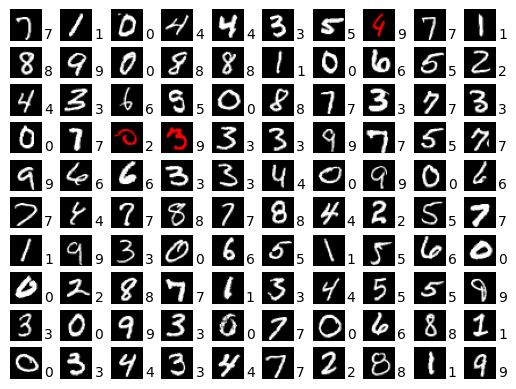

In [17]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = FCNet2()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")

In [36]:
class FCNet3(nn.Module):
    def __init__(self):
        super(FCNet3, self).__init__()
        self.fc1 = nn.Linear(784, 200)
        self.bn1 = nn.BatchNorm1d(200)  # Batch normalization for the first layer
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.bn3 = nn.BatchNorm1d(60)   # Batch normalization for the third layer
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)
        
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.bn1(self.fc1(x)))  # Apply batch norm after first layer
        x = F.relu(self.fc2(x))
        x = F.relu(self.bn3(self.fc3(x)))  # Apply batch norm after third layer
        x = F.relu(self.fc4(x))
        x = self.fc5(x)

        output = F.log_softmax(x, dim=1)
        return output

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.380882
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.340807
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.281581
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.096027
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.171021
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.116496
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.228402
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.209125
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.189248
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.177783

Test set: Average loss: 0.0842, Accuracy: 9744/10000 (97.44%)



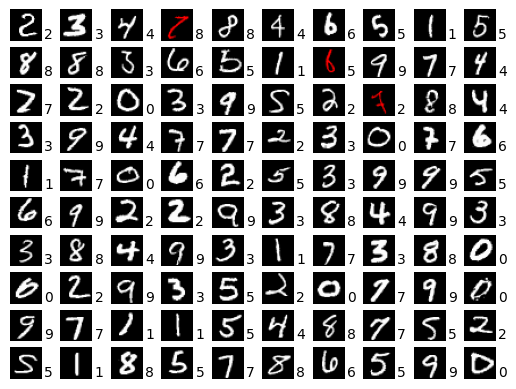

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.095268
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.088274
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.130510
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.029332
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.218950
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.024001
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.009196
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.165770
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.126767
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.113756

Test set: Average loss: 0.0718, Accuracy: 9769/10000 (97.69%)



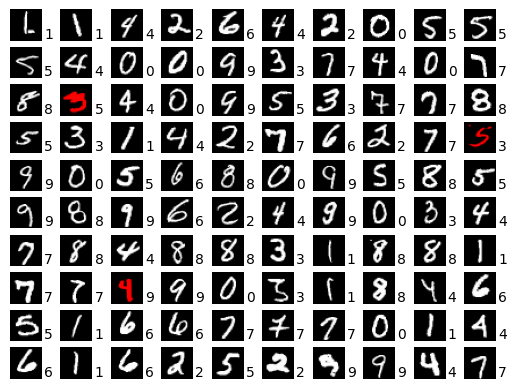

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.033033
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.104530
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.090305
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.115783
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.035436
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.200637
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.036775
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.004901
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.007417
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.043340

Test set: Average loss: 0.0672, Accuracy: 9786/10000 (97.86%)



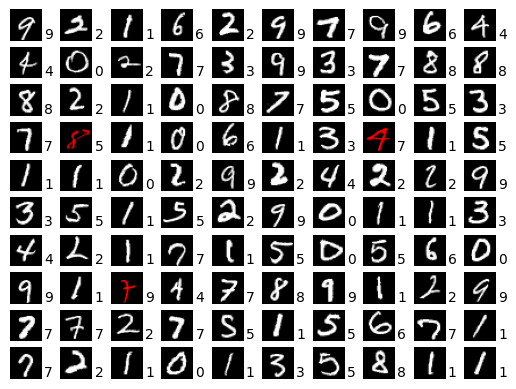

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.031401
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.002133
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.010233
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.012194
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.016673
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.011763
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.004967
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.001820
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.037249
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.043018

Test set: Average loss: 0.0617, Accuracy: 9823/10000 (98.23%)



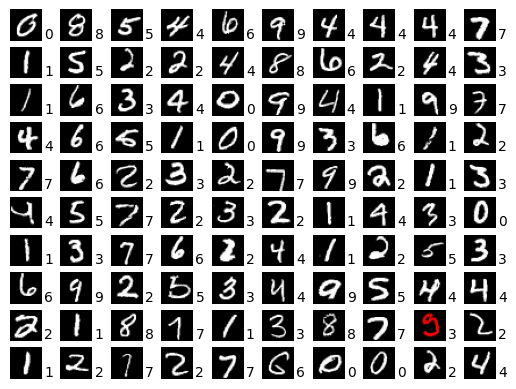

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.006606
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.025010
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.004346
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.078645
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.010001
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.003011
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.004932
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.025458
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.002993
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.004938

Test set: Average loss: 0.0572, Accuracy: 9838/10000 (98.38%)



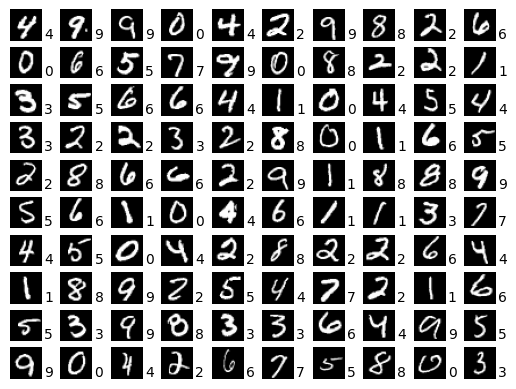

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.001507
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.021030
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.002507
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.014277
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.046689
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.020171
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.000401
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.041486
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.018299
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.019085

Test set: Average loss: 0.0579, Accuracy: 9837/10000 (98.37%)



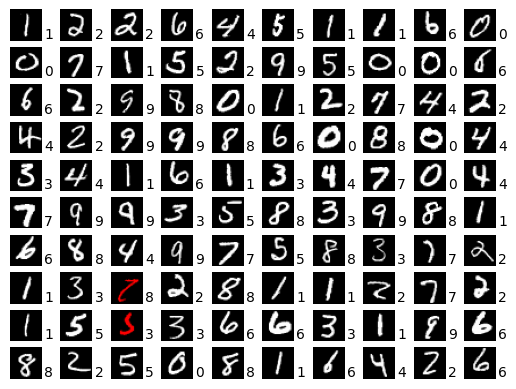

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.002236
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.000863
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.019593
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.026209
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.002151
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.031055
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.001533
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.000907
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.045797
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.001690

Test set: Average loss: 0.0565, Accuracy: 9851/10000 (98.51%)



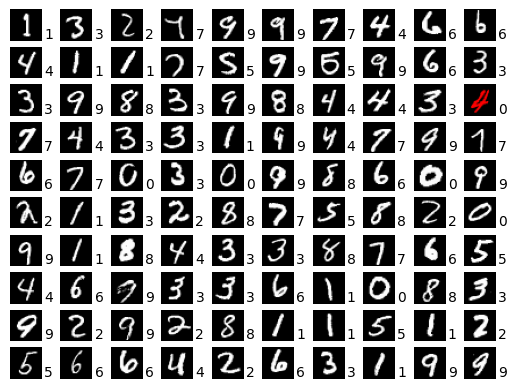

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.015048
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.002336
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.004097
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.000935
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.019115
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.002780
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.001391
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.000330
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.005271
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.015946

Test set: Average loss: 0.0583, Accuracy: 9854/10000 (98.54%)



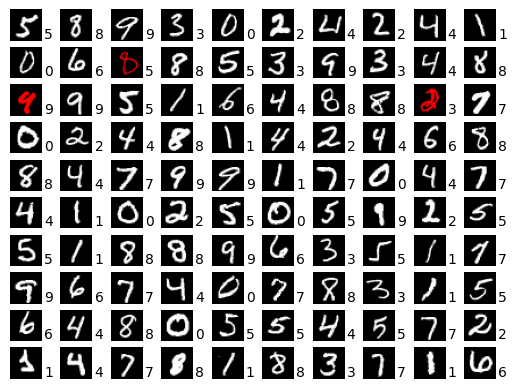

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.030488
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.018358
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.000953
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.078338
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.033311
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.001204
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.025570
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.002531
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.000802
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.048588

Test set: Average loss: 0.0564, Accuracy: 9849/10000 (98.49%)



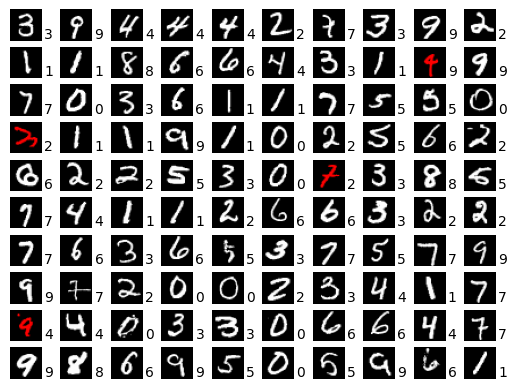

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.000055
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.013058
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.005885
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.010751
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.005499
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.002913
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.006446
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.000776
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.024680
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.002524

Test set: Average loss: 0.0575, Accuracy: 9855/10000 (98.55%)



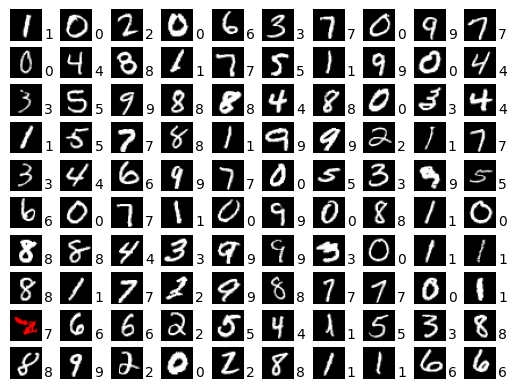

In [37]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = FCNet3()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [33]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        
        # TODO: initialize network layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)  # 1x28x28 -> 32x26x26
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2) # 32x26x26 -> 64x12x12
        
        self.fc1 = nn.Linear(64 * 12 * 12, 128)  # Fully connected layer with input size 64*12*12 and output 128
        self.fc2 = nn.Linear(128, 10)            # Output layer to 10 classes


    def forward(self, x):
        # TODO: run convolutional layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = torch.flatten(x, start_dim=1)
        
        # TODO: run fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297765
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.214638
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.096254
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.186060
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.063183
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.046283
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.107033
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.058798
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.047873
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.025367

Test set: Average loss: 0.0447, Accuracy: 9861/10000 (98.61%)



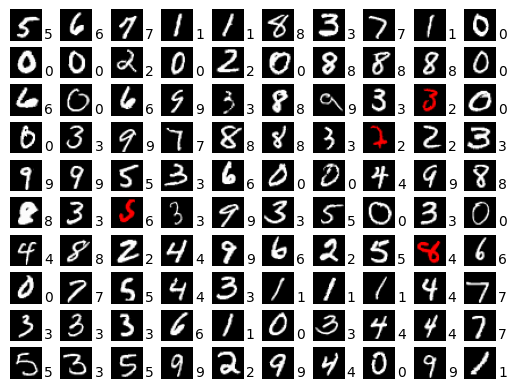

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.078743
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.011795
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.018711
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.053647
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.005028
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.017596
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.124385
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.008013
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.004613
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.009759

Test set: Average loss: 0.0395, Accuracy: 9873/10000 (98.73%)



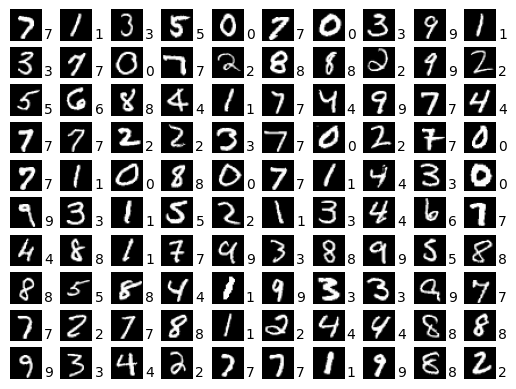

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.014208
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.004059
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.011063
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.000316
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.000823
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.005222
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.000374
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.008602
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.001606
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.001885

Test set: Average loss: 0.0327, Accuracy: 9885/10000 (98.85%)



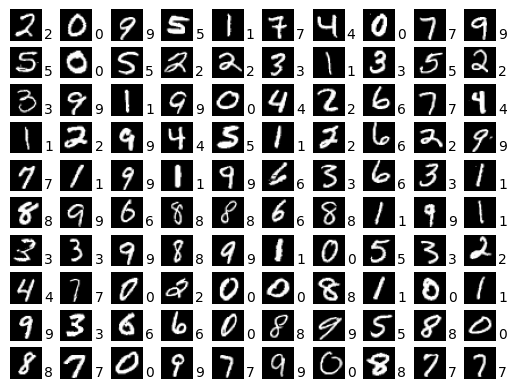

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.001957
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.004536
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.000750
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.001308
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.001028
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.002133
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.000209
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.000745
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.000289
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.005019

Test set: Average loss: 0.0301, Accuracy: 9905/10000 (99.05%)



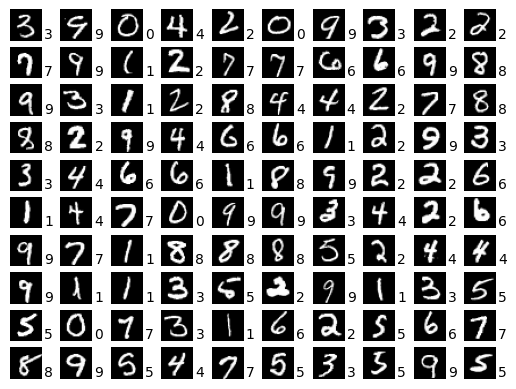

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.000669
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.000301
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.000026
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.002674
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.000789
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.000094
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.000147
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.000313
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.000423
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.000061

Test set: Average loss: 0.0312, Accuracy: 9905/10000 (99.05%)



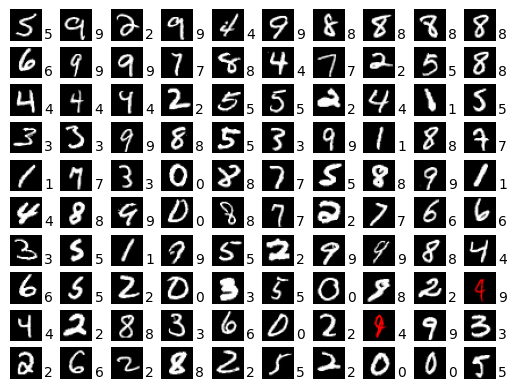

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.000267
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.000175
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.000082
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.000055
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.000205
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.002212
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.000088
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.000267
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.001814
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.000248

Test set: Average loss: 0.0335, Accuracy: 9909/10000 (99.09%)



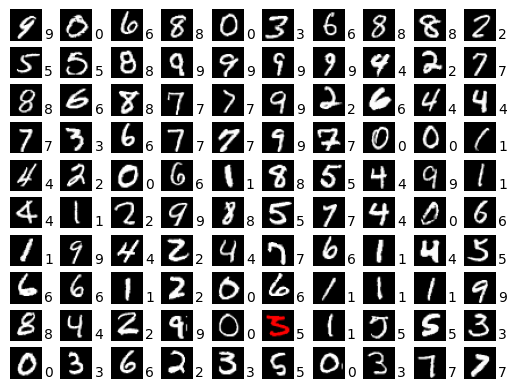

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.003696
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.002337
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.000094
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.000164
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.000000
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.000645
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.000099
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.000415
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.001407
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.000396

Test set: Average loss: 0.0350, Accuracy: 9905/10000 (99.05%)



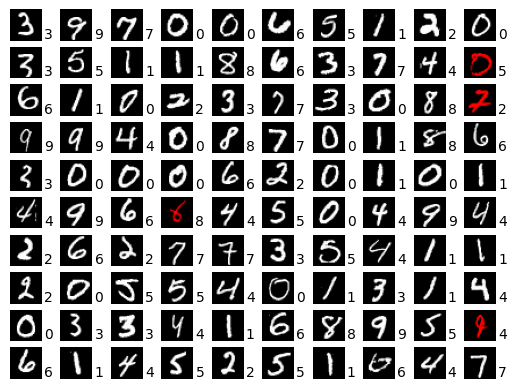

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.000083
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.000504
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.000549
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.000284
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.000155
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.000092
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.000356
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.000407
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.000058
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.000351

Test set: Average loss: 0.0355, Accuracy: 9906/10000 (99.06%)



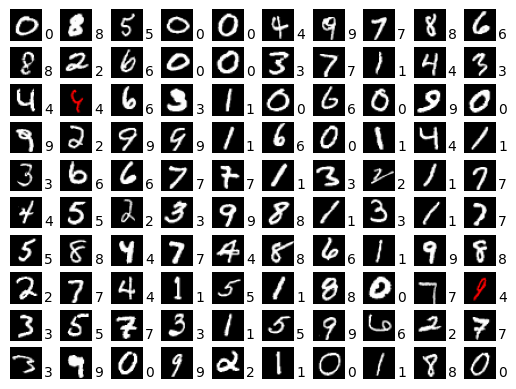

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.000238
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.000002
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.001619
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.000133
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.000054
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.000225
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.000062
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.001674
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.000002
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.000062

Test set: Average loss: 0.0363, Accuracy: 9903/10000 (99.03%)



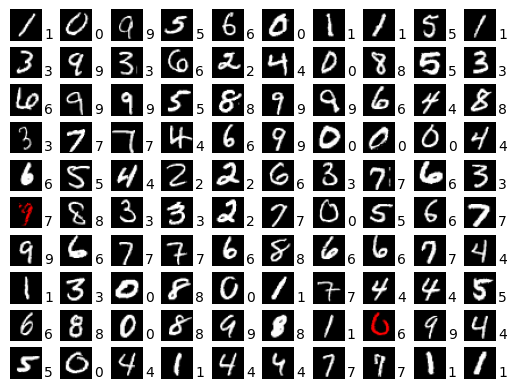

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.000555
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.000091
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.000023
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.000080
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.000327
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.000158
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.000084
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.000145
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.000439
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.000103

Test set: Average loss: 0.0364, Accuracy: 9903/10000 (99.03%)



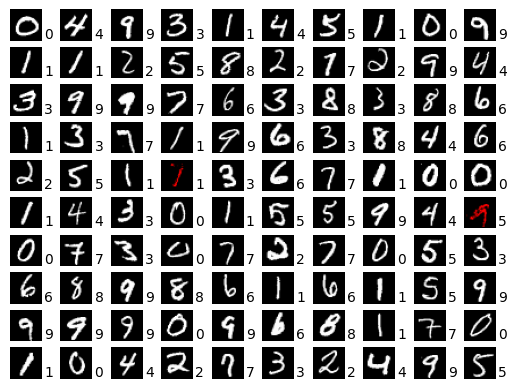

In [38]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = ConvNet1()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")

In [34]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)  
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2) 
        self.fc1 = nn.Linear(64 * 12 * 12, 128) 
        self.bn2 = nn.BatchNorm1d(128)  # Batch normalization
        
        self.fc2 = nn.Linear(128, 10)           

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))  # Apply batch normalization after conv1
        x = F.relu(self.conv2(x)) 
        
        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.bn2(self.fc1(x)))    # Apply batch normalization after fc1

        x = self.fc2(x)
        
        output = F.log_softmax(x, dim=1)
        
        return output

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.385738
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.190732
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.082326
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.089468
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.071205
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.166763
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.061819
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.027064
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.041987
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.027927

Test set: Average loss: 0.0372, Accuracy: 9885/10000 (98.85%)



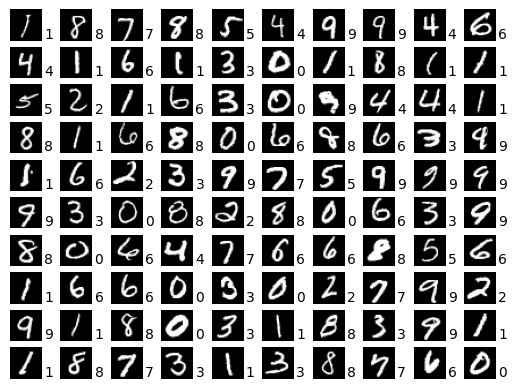

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.063028
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.022171
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.109777
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.005874
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.046281
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.000579
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.034858
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.032503
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.014678
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.028005

Test set: Average loss: 0.0296, Accuracy: 9901/10000 (99.01%)



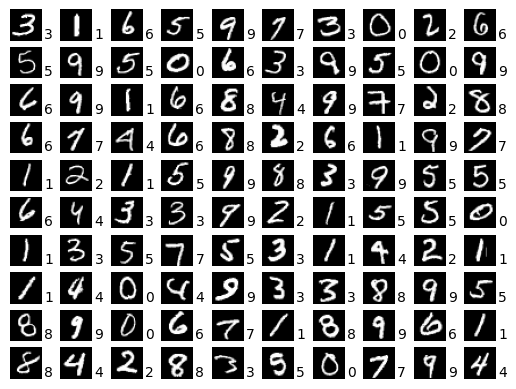

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.040471
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.005524
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.001797
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.010566
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.044732
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.006296
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.002159
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.020107
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.092164
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.014581

Test set: Average loss: 0.0270, Accuracy: 9905/10000 (99.05%)



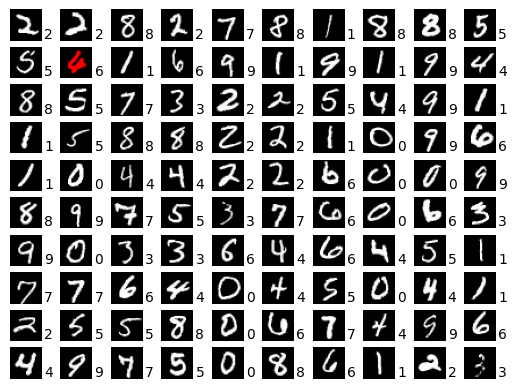

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.009000
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.001638
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.028148
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.006258
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.004192
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.004547
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.036518
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.001510
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.010678
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.004223

Test set: Average loss: 0.0265, Accuracy: 9916/10000 (99.16%)



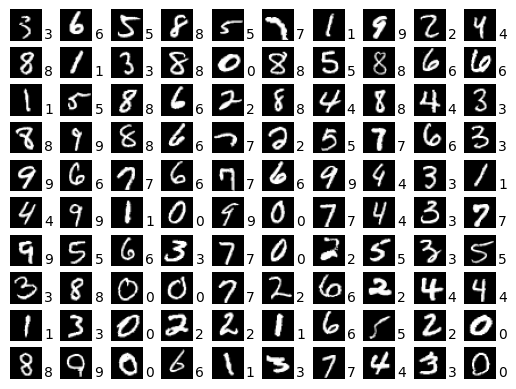

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.000570
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.000176
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.004391
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.000501
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.000975
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.002443
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.003381
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.004799
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.001637
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.001963

Test set: Average loss: 0.0263, Accuracy: 9921/10000 (99.21%)



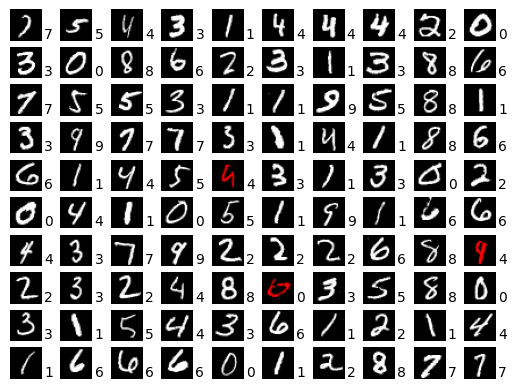

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.000094
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.001086
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.002089
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.008982
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.000396
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.000671
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.001004
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.000537
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.000439
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.000444

Test set: Average loss: 0.0258, Accuracy: 9917/10000 (99.17%)



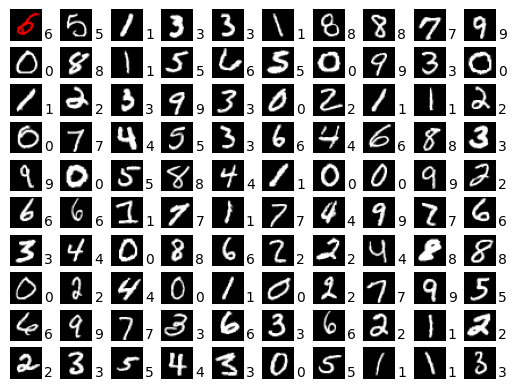

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.008428
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.000804
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.014429
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.002494
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.000612
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.001737
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.002447
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.007394
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.002173
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.001484

Test set: Average loss: 0.0259, Accuracy: 9921/10000 (99.21%)



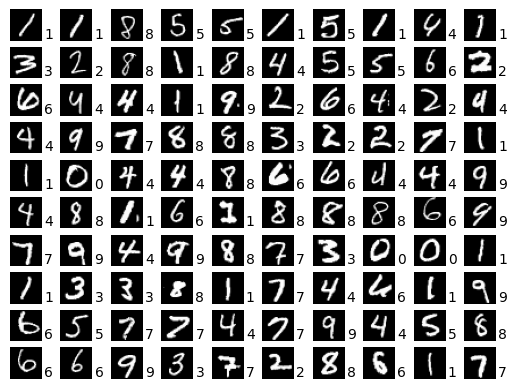

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.000581
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.001729
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.001172
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.000334
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.001744
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.000581
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.001075
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.000044
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.000882
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.000979

Test set: Average loss: 0.0272, Accuracy: 9917/10000 (99.17%)



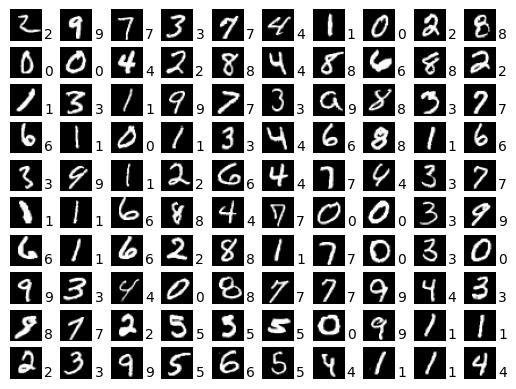

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.000849
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.000951
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.001249
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.000501
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.000381
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.000963
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.000513
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.001411
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.003440
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.000475

Test set: Average loss: 0.0257, Accuracy: 9920/10000 (99.20%)



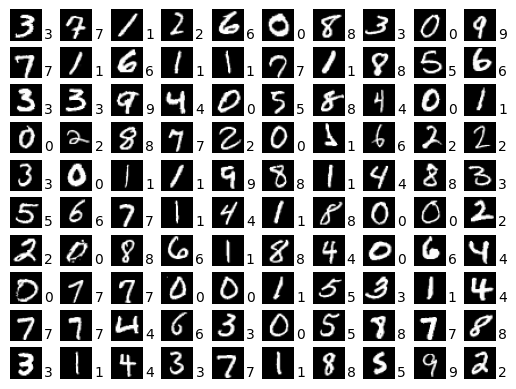

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.003931
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.000943
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.002100
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.000859
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.002122
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.000151
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.001688
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.000391
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.000910
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.000340

Test set: Average loss: 0.0267, Accuracy: 9920/10000 (99.20%)



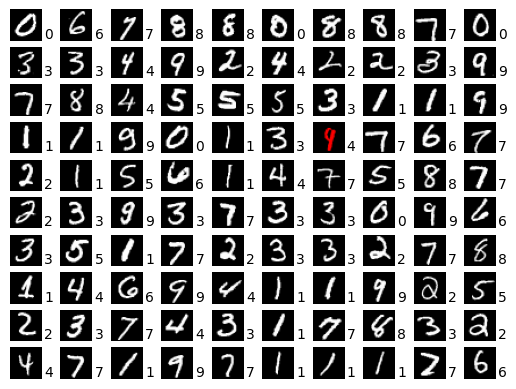

In [39]:
model = ConvNet2()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")

In [35]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3) 
        self.bn1 = nn.BatchNorm2d(32) 
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3) 

        # Max Pooling layers to reduce dimensions
        self.pool = nn.MaxPool2d(kernel_size=2)  # Reduces dimension by half

        self.fc1 = nn.Linear(64 * 12 * 12, 128)  
        
        self.bn2 = nn.BatchNorm1d(128)
        
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x))) 
        x = F.relu(self.pool(self.conv2(x))) 

        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.bn2(self.fc1(x)))  

        x = self.fc2(x)
        
        output = F.log_softmax(x, dim=1)
        
        return output

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.521363
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.169581
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.120366
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.084727
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.230132
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.078973
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.046115
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.008417
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.206842
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.106245

Test set: Average loss: 0.0374, Accuracy: 9874/10000 (98.74%)



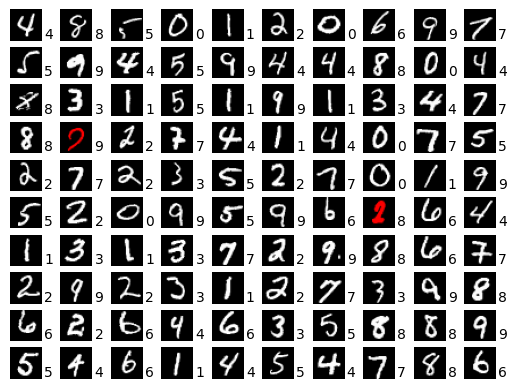

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.108341
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.082858
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.008464
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.007777
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.013330
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.008383
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.003523
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.015456
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.002320
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.077336

Test set: Average loss: 0.0295, Accuracy: 9893/10000 (98.93%)



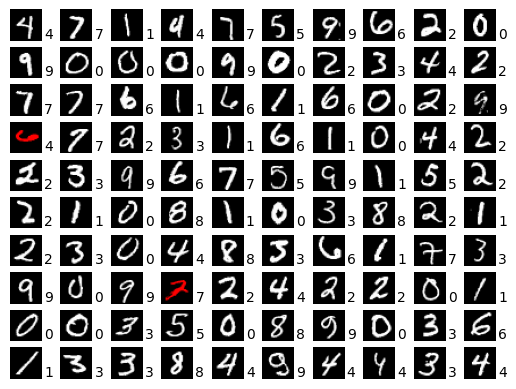

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.012269
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.002634
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.002252
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.003232
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.030244
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.035975
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.032981
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.005441
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.003112
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.006153

Test set: Average loss: 0.0241, Accuracy: 9921/10000 (99.21%)



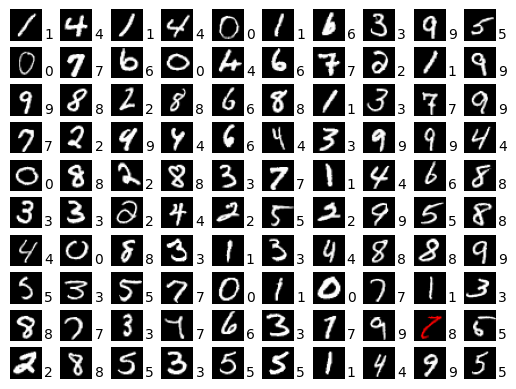

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.003001
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.003216
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.005882
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.018008
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.012385
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.005073
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.002278
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.003368
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.003191
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.000800

Test set: Average loss: 0.0238, Accuracy: 9921/10000 (99.21%)



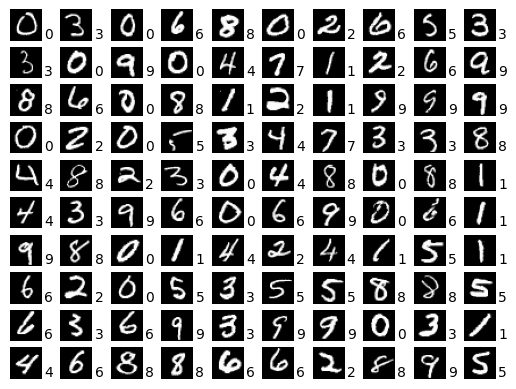

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.001082
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.000570
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.002569
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.000896
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.005948
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.004477
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.005902
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.003523
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.015043
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.002582

Test set: Average loss: 0.0243, Accuracy: 9924/10000 (99.24%)



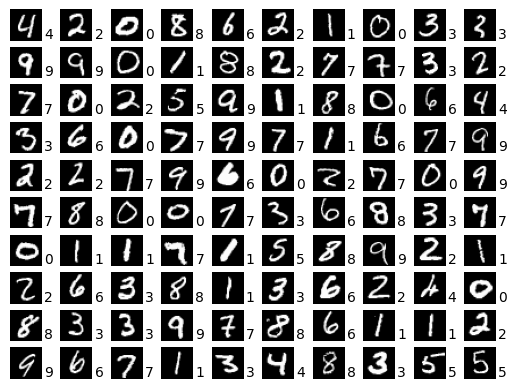

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.000294
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.003026
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.001084
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.002108
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.022889
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.002056
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.000669
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.002385
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.000736
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.000473

Test set: Average loss: 0.0235, Accuracy: 9924/10000 (99.24%)



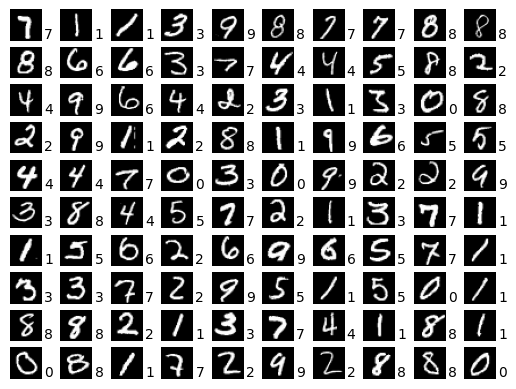

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.000875
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.001976
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.000905
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.000690
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.000546
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.000730
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.001668
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.001209
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.002967
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.000370

Test set: Average loss: 0.0242, Accuracy: 9920/10000 (99.20%)



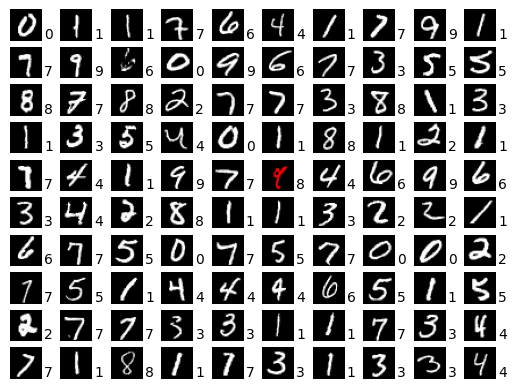

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.002798
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.001420
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.000318
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.000509
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.001058
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.002103
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.000419
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.000541
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.000911
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.000568

Test set: Average loss: 0.0237, Accuracy: 9930/10000 (99.30%)



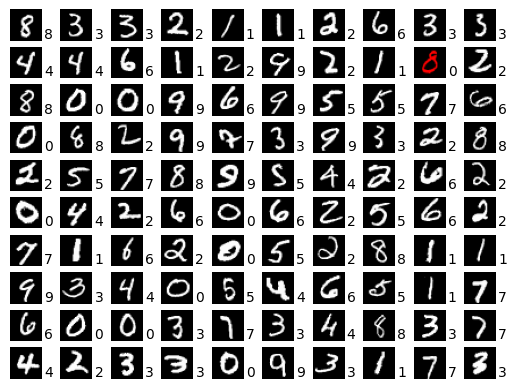

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.001998
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.000407
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.001035
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.000545
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.001021
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.000335
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.005255
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.001234
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.000397
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.002237

Test set: Average loss: 0.0233, Accuracy: 9929/10000 (99.29%)



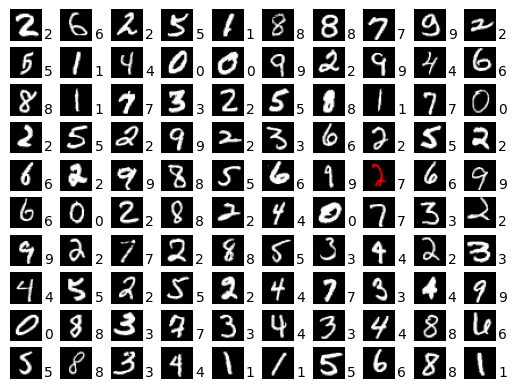

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.000629
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.001640
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.001518
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.000169
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.005015
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.000737
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.002928
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.000351
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.002319
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.000402

Test set: Average loss: 0.0237, Accuracy: 9924/10000 (99.24%)



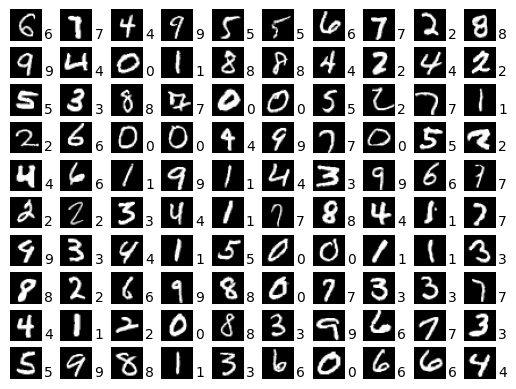

In [40]:
model = ConvNet3()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")